<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/pairs_trading_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Commodities Mean Reversion Trading Strategy

In it's most simple form, all trading strategies can be classified as either momentum or mean reversion. Commodities are often fungible, that is interchangeable to a certain degree. This in turn implies both a positive correlation, as well as cointegration, between a select number of commodity pairs. This project will explore a mean reverting pairs trading strategy between two commodities. For illustrative purposes, the commodities chosen are CME corn and SRW wheat futures applied to the continuous futures front month contract.

### Import libraries

In [137]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# financial analysis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import yfinance as yf #Yahoo! Finance API

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# surpress warnings
pd.options.mode.chained_assignment = None # chained assignments

### USER INPUT: range and trading pair

In [138]:
# date range
start = '2012-01-01' # YYYY-MM-DD format
end = datetime.now() - timedelta(1)

# trading pair
product1_name = 'Corn'
product1_ticker = 'ZC=F'
product2_name = 'SRW'
product2_ticker = 'ZW=F'

### Fetching price data

In [139]:
def create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker):

  # fetch data for first product
  data1 = yf.download(product1_ticker, start=start, end=end)
  data1.rename(columns={'Adj Close':product1_name}, inplace=True)

  # fetch data for second product
  data2 = yf.download(product2_ticker, start=start, end=end)
  data2.rename(columns={'Adj Close':product2_name}, inplace=True)

  # create a pairs dataframe
  pairs_df = pd.concat([data1[product1_name], data2[product2_name]], axis=1)
  pairs_df.fillna(method='ffill', inplace=True)

  return pairs_df

pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### USER INPUT: hyperparameters

In [165]:
lookback = 90
entry_threshold = 2
exit_threshold = 1

### Calculate spread and z-score

In [169]:
def calc_spread_zscore(pairs_df, lookback):

  # fit a rolling linear regression between the two products
  model = RollingOLS(endog=pairs_df.iloc[:,0],
                     exog=sm.add_constant(pairs_df.iloc[:,1]),
                     window=lookback)
  rolling_res = model.fit()
  params = rolling_res.params.copy()

  # calculate the hedge ratio
  pairs_df['hedge_ratio'] = params.iloc[:,1]
  pairs_df.dropna(inplace=True)

  # calculate the spread and z-score
  # apply log function to make the series stationary
  pairs_df['spread'] = np.log(pairs_df.iloc[:,0]) - pairs_df['hedge_ratio'] * np.log(pairs_df.iloc[:,1])
  pairs_df['zscore'] = (pairs_df['spread'] - np.mean(pairs_df['spread'])) / np.std(pairs_df['spread'])

  return pairs_df

pairs_df = calc_spread_zscore(pairs_df, lookback)

### Define trading rules

In [142]:
def get_trading_signals(pairs_df, entry_threshold, exit_threshold):

  pairs_df['longs'] = (pairs_df['zscore'] <= -entry_threshold)*1.0
  pairs_df['shorts'] = (pairs_df['zscore'] >= entry_threshold)*1.0
  pairs_df['exits'] = (np.abs(pairs_df['zscore']) <= exit_threshold)*1.0

  pairs_df['long_market'] = 0.0
  pairs_df['short_market'] = 0.0

  long_market = 0
  short_market = 0

  for i, b in enumerate(pairs_df.iterrows()):
    # calculate longs
    if b[1]['longs'] == 1.0:
        long_market = 1            
    # calculate shorts
    if b[1]['shorts'] == 1.0:
        short_market = 1
    # calculate exists
    if b[1]['exits'] == 1.0:
        long_market = 0
        short_market = 0

    pairs_df.iloc[i]['long_market'] = long_market
    pairs_df.iloc[i]['short_market'] = short_market

  return pairs_df

pairs_df = get_trading_signals(pairs_df, entry_threshold, exit_threshold)

### Portfolio performance metrics

In [143]:
def get_pairs_returns(pairs_df, product1_name, product2_name):

  # create portfolio
  portfolio = pd.DataFrame(index=pairs_df.index)
  portfolio['positions'] = pairs_df['long_market'] - pairs_df['short_market']
  portfolio[product1_name] = -1.0 * pairs_df.iloc[:, 0] * portfolio['positions']
  portfolio[product2_name] = pairs_df.iloc[:, 1] * portfolio['positions']
  portfolio['total'] = portfolio.iloc[:, 0] + portfolio.iloc[:, 1]

  # create equity curve
  portfolio['returns'] = portfolio['total'].pct_change()
  portfolio['returns'].fillna(0.0, inplace=True)
  portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
  portfolio['returns'].replace(-1.0, 0.0, inplace=True)
  portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()

  return portfolio

pairs_returns_df = get_pairs_returns(pairs_df, product1_name, product2_name)

In [162]:
universe = [{'product1_name':'corn',
             'product1_ticker':'ZC=F',
             'product2_name':'srw',
             'product2_ticker':'ZW=F'
             },
            {'product1_name':'hrw',
             'product1_ticker':'KE=F',
             'product2_name':'srw',
             'product2_ticker':'ZW=F'
             },
            {'product1_name':'gold',
             'product1_ticker':'GC=F',
             'product2_name':'silver',
             'product2_ticker':'SI=F'
             },
            {'product1_name':'soybean',
             'product1_ticker':'ZS=F',
             'product2_name':'soymeal',
             'product2_ticker':'ZM=F'
             },
            {'product1_name':'soybean',
             'product1_ticker':'ZS=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },
            {'product1_name':'soymeal',
             'product1_ticker':'ZM=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },
            {'product1_name':'gold',
             'product1_ticker':'GC=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },
            {'product1_name':'silver',
             'product1_ticker':'SI=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },
            ]

In [170]:
def get_portfolio_returns(universe):

  # create empty list of dataframes
  returns = []

  # loop through all pairs in universe
  for pair in universe:
    pairs_df = create_pairs_df(pair['product1_name'], pair['product1_ticker'],
                               pair['product2_name'], pair['product2_ticker'])
    pairs_df = calc_spread_zscore(pairs_df, lookback)
    pairs_df = get_trading_signals(pairs_df, entry_threshold, exit_threshold)
    pairs_returns_df = get_pairs_returns(pairs_df, pair['product1_name'], pair['product2_name'])
    returns.append(pairs_returns_df['returns'])

  # create dataframe from list and calculate mean returns
  returns_df = pd.DataFrame(returns).T
  returns_df['mean_return'] = returns_df.mean(axis=1)

  return returns_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<Axes: xlabel='Date'>

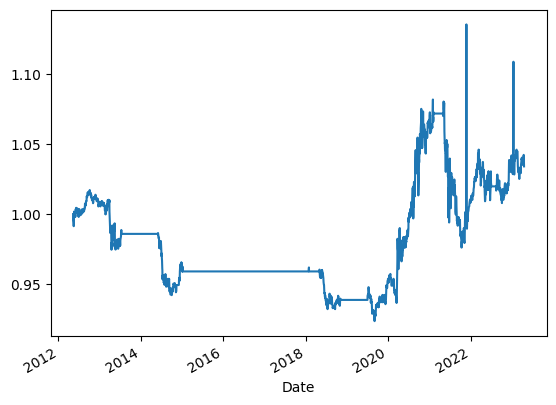

In [171]:
test = get_portfolio_returns(universe)
test['mean_return'].plot()

### Making the series stationary

In order to implement a mean reverting strategy we first have to ensure our data is stationary, which simply means a constant mean and variance. A simple test is a quick visual inspection, however a more robust statistical test is the Augmented Dicky-Fuller (ADF) test. A typical $a$ is 0.05 and we reject the null hypothesis, i.e. fail to reject our alternative hypothesis that our data is non-stationary, when our p-value is below this threshold.

#### Price ratio

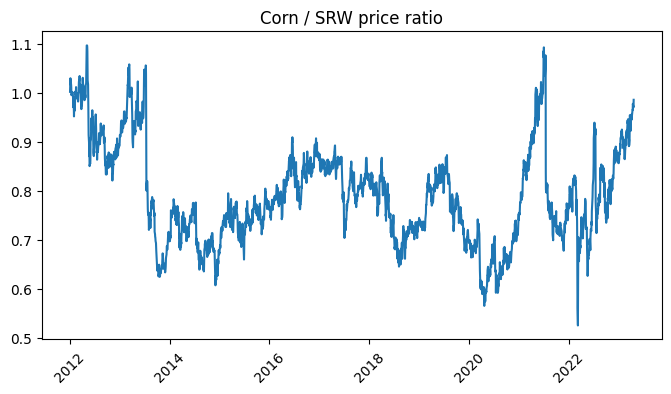

ADF statistic:
-3.557792 

p-value: 
0.006621 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


In [4]:
# calculate ratio
# hedge_ratio = 1
# spread = np.log(prices[product1_name]) - (hedge_ratio * np.log(prices[product2_name]))
ratio = prices[product1_name] / prices[product2_name]

# plot ratio
plt.subplots(figsize=(8, 4))
plt.plot(ratio.index, ratio)
plt.title(f'{product1_name} / {product2_name} price ratio')
plt.xticks(rotation=45)
plt.show()

# checking for stationarity
result = adfuller(ratio)
print('ADF statistic:\n%f' % result[0], '\n')
print('p-value: \n%f' % result[1], '\n')
print('Critical values:')
for key, value in result[4].items():
  print('%s @ %.3f' % (key, value))

#### Price ratio log returns

In order to make our series stationary we perform a log transformation followed by differencing $t$ and $t_{-1}$, which gives us log returns.

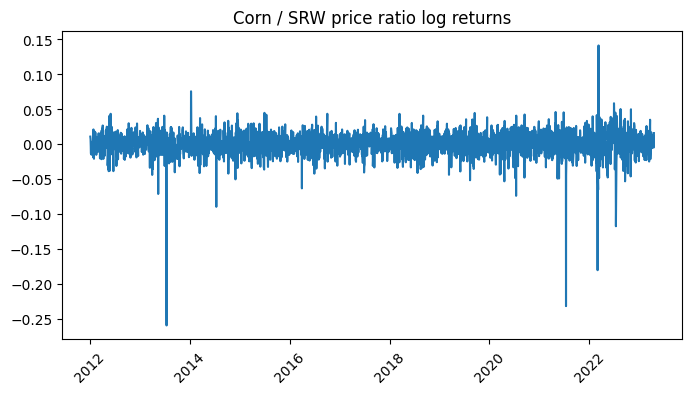

ADF statistic:
-17.669948 

p-value: 
0.000000 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


In [5]:
# calculate log returns
ratio_log_returns = np.log(ratio).diff().dropna()

# plot log returns
plt.subplots(figsize=(8, 4))
plt.plot(ratio_log_returns.index, ratio_log_returns)
plt.title(f'{product1_name} / {product2_name} price ratio log returns')
plt.xticks(rotation=45)
plt.show()

# checking for stationarity
result = adfuller(ratio_log_returns)
print('ADF statistic:\n%f' % result[0], '\n')
print('p-value: \n%f' % result[1], '\n')
print('Critical values:')
for key, value in result[4].items():
	print('%s @ %.3f' % (key, value))

### Trading strategy

Our base strategy is essentially a Bollinger Bands strategy, which means only a few adjustable hyperparameters, namely the lookback window and standard deviation. Another potential adjustment is whether to use a SMA or EWMA, which we will leave as a future exercise.

#### USER INPUT: hyperparameters

In [6]:
# hyperparameters
lookback = 30
threshold = 2
allocation1 = 0.5
allocation2 = (1-allocation1)

In [7]:
# calculating rolling mean and std
df = pd.DataFrame(ratio_log_returns, columns=['log_returns'])
df['mean'] = df['log_returns'].rolling(window=lookback).mean()
df['std'] = df['log_returns'].rolling(window=lookback).std()
df['upper_band'] = df['mean'] + threshold * df['std']
df['lower_band'] = df['mean'] - threshold * df['std']

#### Bollinger Bands

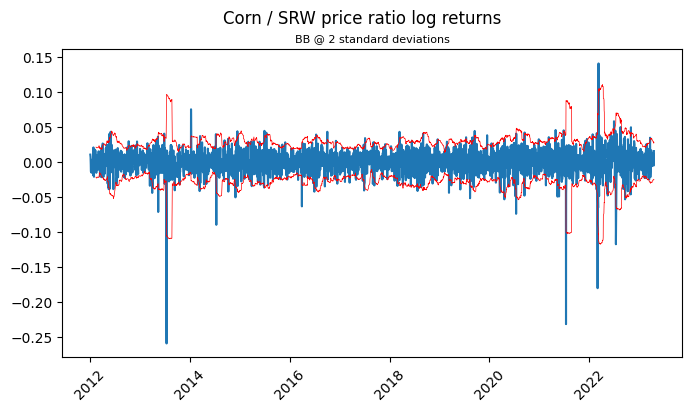

In [8]:
# plot bollinger bands
plt.subplots(figsize=(8, 4))
plt.plot(ratio_log_returns.index, ratio_log_returns)
plt.plot(ratio_log_returns.index, df['upper_band'], color='r', linewidth=0.5)
plt.plot(ratio_log_returns.index, df['lower_band'], color='r', linewidth=0.5)
plt.suptitle(f'{product1_name} / {product2_name} price ratio log returns')
plt.title(f'BB @ {threshold} standard deviations', fontsize=8)
plt.xticks(rotation=45)
plt.show()

#### Setting up entry and exit rules

 0    2663
-1     155
 1      21
Name: signal, dtype: int64


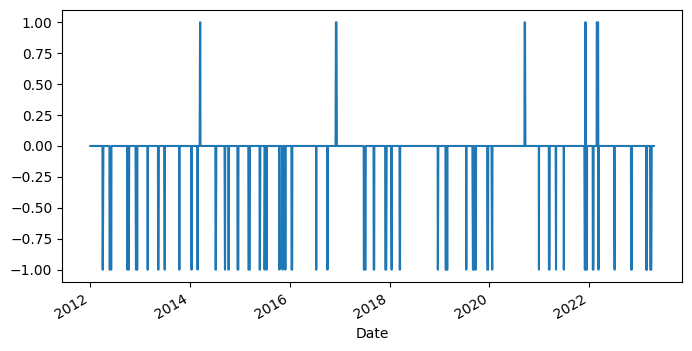

In [9]:
# add signal column to dataframe
df['signal'] = 0

# define trading rules
for i in range(1, len(df)):
  
  # from hold to (sell or buy)
  if df['signal'][i-1] == 0:
    if (df['log_returns'][i-1] > df['upper_band'][i-1]) and \
          (df['log_returns'][i] <= df['upper_band'][i]):
       df['signal'][i] = -1
    elif (df['log_returns'][i-1] < df['lower_band'][i-1]) and \
          (df['log_returns'][i] >= df['upper_band'][i]):
       df['signal'][i] = 1
    else:
       df['signal'][i] = 0
  
  # from sell to hold
  elif df['signal'][i-1] == -1:
    if (df['log_returns'][i-1] > df['mean'][i-1]) and \
          (df['log_returns'][i] <= df['mean'][i]):
       df['signal'][i] = 0
    else:
       df['signal'][i] = -1
  
  # from buy to hold
  elif df['signal'][i-1] == 1:
    if (df['log_returns'][i-1] < df['mean'][i-1]) and \
          (df['log_returns'][i] >= df['mean'][i]):
       df['signal'][i] = 0
    else:
       df['signal'][i] = 1

# calculate # trade days
print(df['signal'].value_counts())

# plot signal
plt.subplots(figsize=(8, 4))
df['signal'].plot();

In [10]:
pairs_df = pd.concat([prices, df['signal']], axis=1)
pairs_df[f'{product1_name}_daily_ret'] = pairs_df[f'{product1_name}'].pct_change()
pairs_df[f'{product2_name}_daily_ret'] = pairs_df[f'{product2_name}'].pct_change()

pairs_df['portfolio_daily_returns'] = (allocation1 * pairs_df['signal'].shift(1) * pairs_df[f'{product1_name}_daily_ret']) + \
                                     (allocation2 * -pairs_df['signal'].shift(1) * pairs_df[f'{product1_name}_daily_ret'])
pairs_df['portfolio_cumulative_returns'] = (1 + pairs_df['portfolio_daily_returns']).cumprod()

pairs_df

,Corn,SRW,signal,Corn_daily_ret,SRW_daily_ret,portfolio_daily_returns,portfolio_cumulative_returns
Date,,,,,,,
2012-01-03,658.50,657.00,NaN,NaN,NaN,NaN,NaN
2012-01-04,658.50,650.00,0.0,0.000000,-0.010654,NaN,NaN
2012-01-05,643.50,629.25,0.0,-0.022779,-0.031923,0.0,1.0
2012-01-06,643.50,624.75,0.0,0.000000,-0.007151,0.0,1.0
2012-01-09,652.00,641.75,0.0,0.013209,0.027211,0.0,1.0
...,...,...,...,...,...,...,...
2023-04-13,652.25,667.00,0.0,-0.005716,-0.018396,0.0,1.0
2023-04-14,666.25,682.50,0.0,0.021464,0.023238,0.0,1.0
2023-04-17,676.50,696.50,0.0,0.015385,0.020513,0.0,1.0


### Notes

Explanatory variables:
- Log returns of price ratio
- Volume, OI for each leg
- Call and put options volume, OI for each leg
- Options net delta
- Other correlated commodities prices
- WTI, Brent prices
- GSCI, S&P500
- VIX
- USD/EUR, USD/AUD, USD/CAD, USD/BRL

*Note: For all above variables their $n$ lagged values may be considered.*

# END